# SynCAN Ensemble Evaluation (In Progress)
### Created: Jan 27, 2023
---
This notebook contains a pipeline for evaluating the anomaly detection performance for an ensemble model which contains models trained on all 10 message IDs. This is necessary due to the way the SynCAN dataset is labeled, i.e., the anomalies in the test sets only affect certain message IDs even though all messages which occur within the timeframe of the anomaly are labeled with a 1. This means evaluation performed on a single message ID will lead to many false negatives even though they should be true negatives.

# Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from psutil import virtual_memory
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(f'GPU: {gpu_info[599:619]}')
ram_gb = virtual_memory().total / 1e9
print(f'RAM: {ram_gb:.1f} GB')

GPU: 
RAM: 13.6 GB


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import confusion_matrix, balanced_accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# signal_counts = [2, 3, 2, 1, 2, 2, 2, 1, 1, 4] # number of signals contained in each message ID
TIME_STEPS = 100
SEQ_STRIDE = TIME_STEPS // 2 # must be <= TIME_STEPS
DIRECTORY = "/content/drive/MyDrive/Colab Notebooks/models/cids/"
EVAL_SET = 'continuous'

In [ ]:
models = []
for i in range(10):
    path = DIRECTORY+'id'+str(i+1)+'_model_'+str(TIME_STEPS)+'.h5'
    model = tf.keras.models.load_model(path)
    models.append(model)


# Preparing the SynCAN Dataset

In [ ]:
# Download SynCAN dataset from the ETAS github
!git clone https://github.com/etas/SynCAN.git &> /dev/null
!unzip ./SynCAN/\*.zip -d ./SynCAN/. &> /dev/null
!rm ./SynCAN/*.zip &> /dev/null

In [ ]:
def prepare_train_dataframes(start_time=0, end_time=None):
    df = pd.read_csv('/content/SynCAN/train_1.csv')
    df['Time'] = df['Time'] - df['Time'].min()      # set starting time to 0
    df = df.set_index(df['Time'])
    end_time = df.Time.max() if not end_time else end_time
    df = df[((df.Time >= start_time) & (df.Time < end_time))]
    # display(df)
    print(f'{len(df):,} total messages (id1,id2,...,id10)\n')
    dataframes = []
    for i in range(10):
        msg_id = 'id'+str(i+1)
        id_df = df[df.ID==msg_id]
        id_df = id_df.dropna(axis=1, how='all') # remove unused signal columns
        length = (len(id_df) // SEQ_STRIDE) * SEQ_STRIDE
        id_df = id_df.iloc[:length]
        dataframes.append(id_df)
        print(f'{msg_id.upper()}: {len(id_df):,} messages')
    return dataframes

In [ ]:
train_dataframes = prepare_train_dataframes(0, 1e6)

477,741 total messages (id1,id2,...,id10)

ID1: 66,650 messages
ID2: 33,300 messages
ID3: 66,650 messages
ID4: 22,200 messages
ID5: 66,650 messages
ID6: 33,300 messages
ID7: 66,650 messages
ID8: 66,650 messages
ID9: 33,300 messages
ID10: 22,200 messages


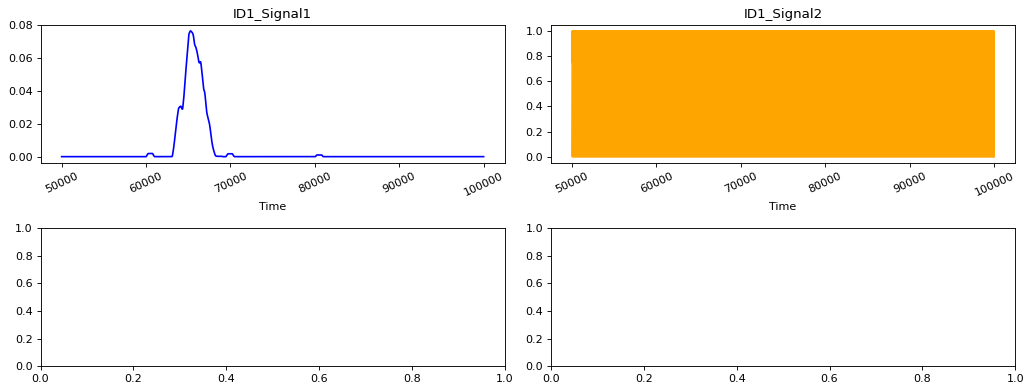

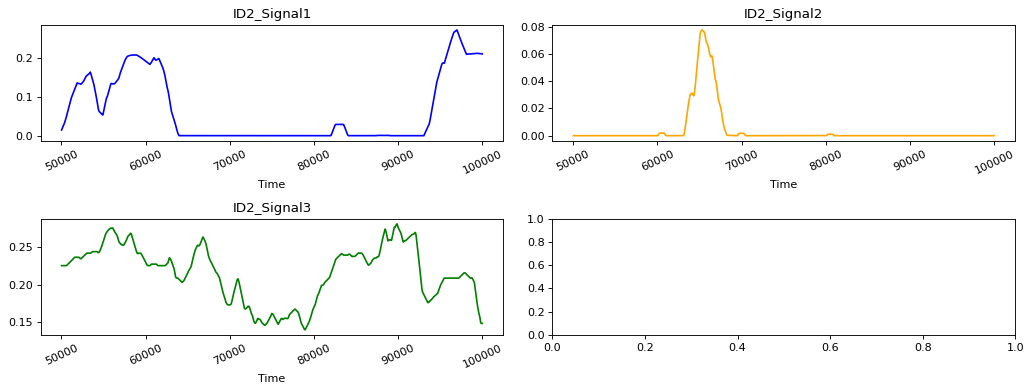

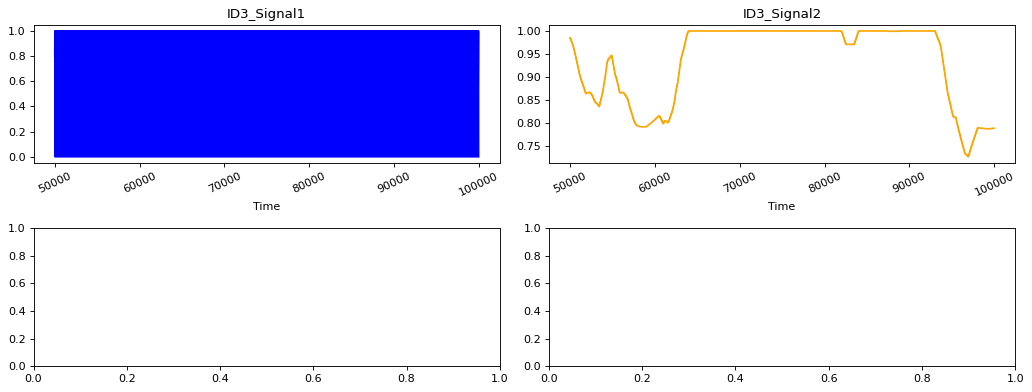

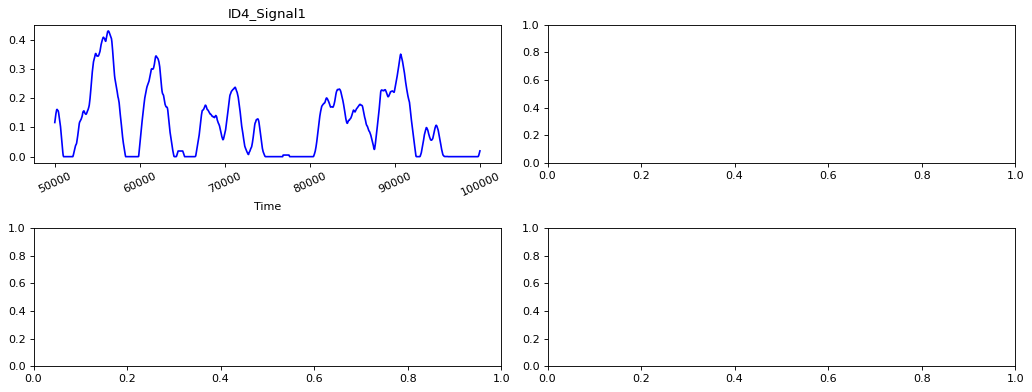

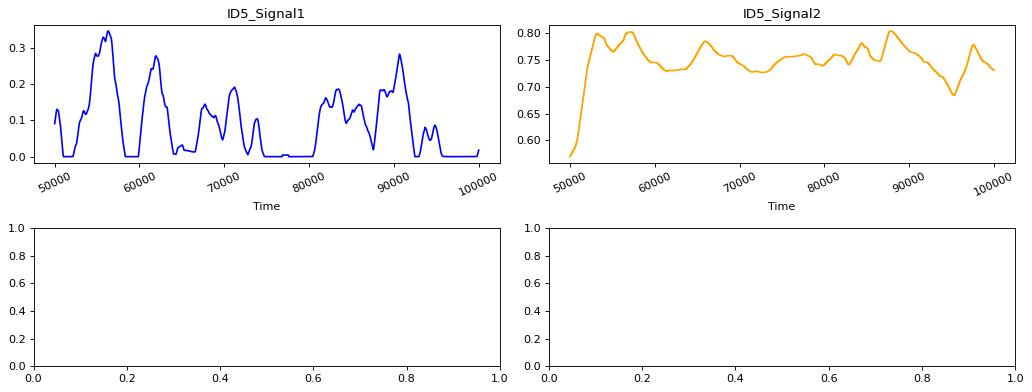

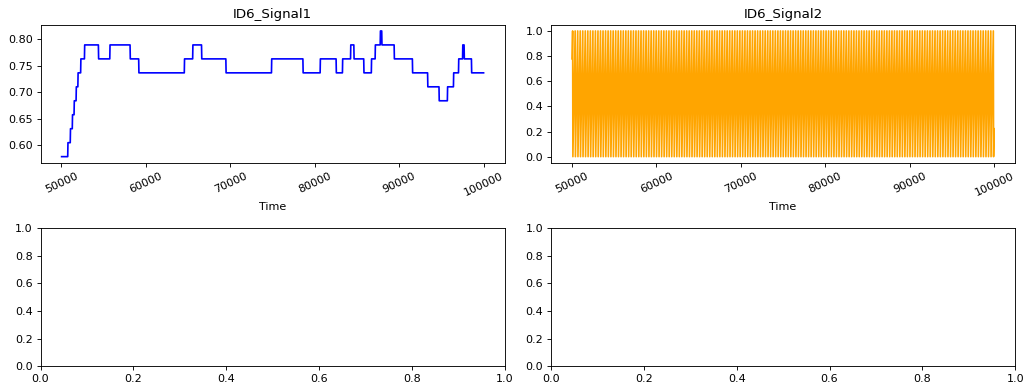

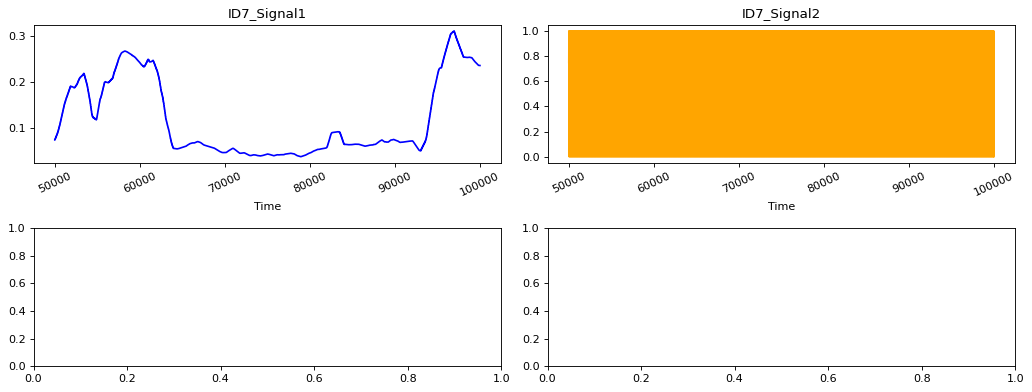

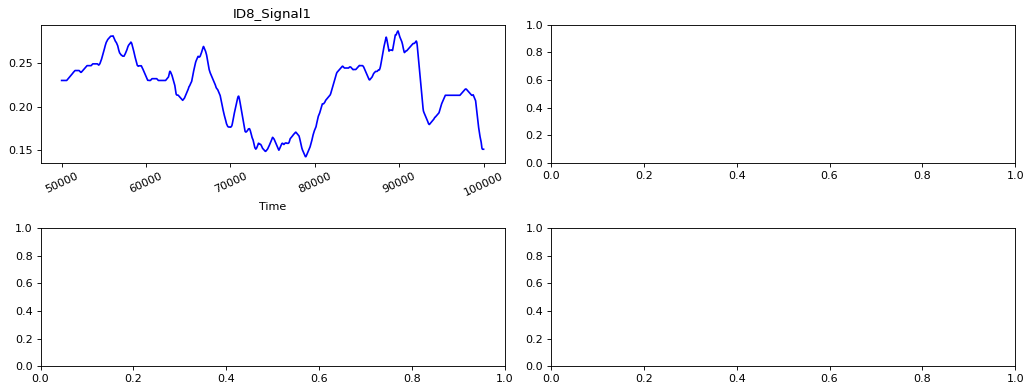

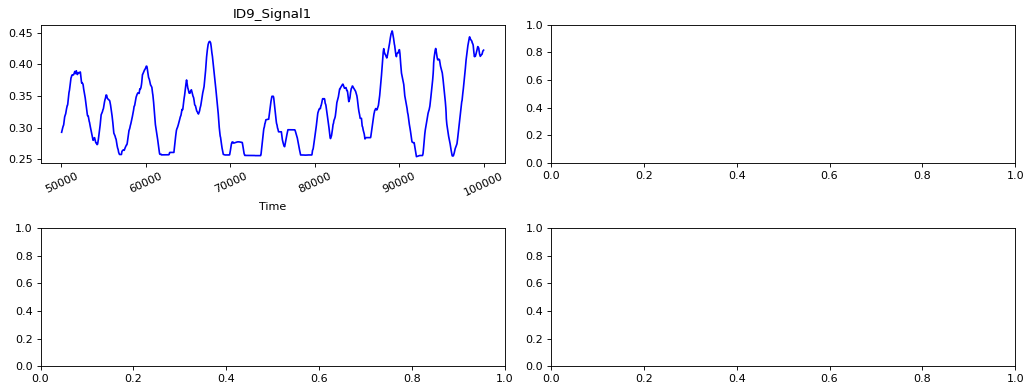

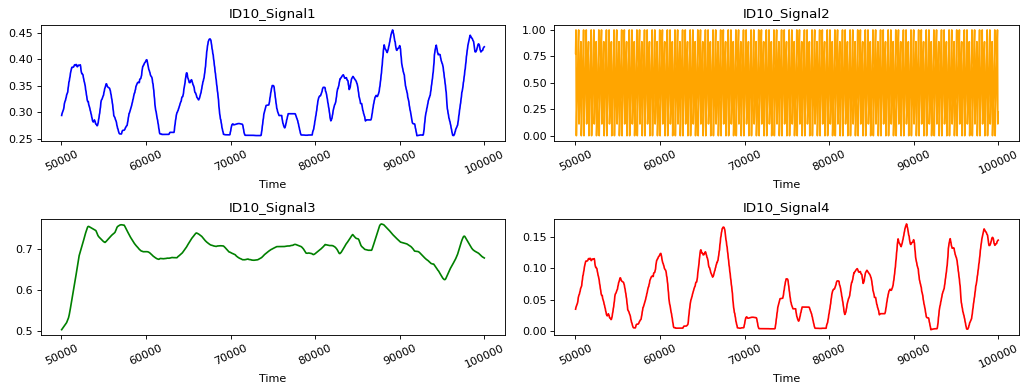

In [ ]:
def visualize_data(df, start_time=0, end_time=None):
    end_time = df.Time.max() if not end_time else end_time
    data = df[((df.Time >= start_time) & (df.Time < end_time))]
    msg_id = data.ID.iloc[0]
    colors = ['blue', 'orange', 'green', 'red']
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(13, 5), dpi=80, facecolor='w', edgecolor='k')
    for i in range(df.shape[1]-3):
        key = 'Signal'+str(i+1)
        c = colors[i % (len(colors))]
        t_data = data[key]
        ax = t_data.plot(
            ax = axes[i // 2, i % 2],
            color = c,
            title = msg_id.upper()+'_'+key,
            rot = 25,
        )
    plt.tight_layout()
    plt.show()

for id_df in train_dataframes:
    visualize_data(id_df, 5e4, 1e5)

In [ ]:
def timeseries_dataset(
    data,
    targets=None,
    sequence_length=TIME_STEPS,
    sequence_stride=SEQ_STRIDE,
    batch_size=1):
  
  sampling_rate=1
  start_index = 0
  end_index = len(data)

  # Determine the lowest dtype to store start positions (to lower memory usage).
  num_seqs = end_index - start_index - (sequence_length * sampling_rate) + 1
  index_dtype = 'int32'

  # Generate start positions
  start_positions = np.arange(0, num_seqs, sequence_stride, dtype=index_dtype)
  sequence_length = tf.cast(sequence_length, dtype=index_dtype)
  sampling_rate = tf.cast(sampling_rate, dtype=index_dtype)

  positions_ds = tf.data.Dataset.from_tensors(start_positions).repeat()

  # For each initial window position, generates indices of the window elements
  indices = tf.data.Dataset.zip(
      (tf.data.Dataset.range(len(start_positions)), positions_ds)).map(
          lambda i, positions: tf.range(  # pylint: disable=g-long-lambda
              positions[i],
              positions[i] + sequence_length * sampling_rate,
              sampling_rate),
          num_parallel_calls=tf.data.AUTOTUNE)

  dataset = sequences_from_indices(data, indices, start_index, end_index)
  if targets is not None:
    indices = tf.data.Dataset.zip(
        (tf.data.Dataset.range(len(start_positions)), positions_ds)).map(
            lambda i, positions: positions[i],
            num_parallel_calls=tf.data.AUTOTUNE)
    target_ds = sequences_from_indices(
        targets, indices, start_index, end_index)
    dataset = tf.data.Dataset.zip((dataset, target_ds))

  dataset = dataset.prefetch(tf.data.AUTOTUNE)
  if batch_size is not None:
    dataset = dataset.batch(batch_size)

  return dataset

def sequences_from_indices(array, indices_ds, start_index, end_index):
    dataset = tf.data.Dataset.from_tensors(array[start_index : end_index])
    dataset = tf.data.Dataset.zip((dataset.repeat(), indices_ds)).map(
        lambda steps, inds: tf.gather(steps, inds),  # pylint: disable=unnecessary-lambda
        num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

def SynCAN_ds(df):
    values = df.values[:,3:].astype('float32')
    ds = timeseries_dataset(values)
    return ds

In [ ]:
train_datasets = [SynCAN_ds(id_df) for id_df in train_dataframes]
for i, ds in enumerate(train_datasets, 1):
    print(f'ID {i}:\t{ds.__len__().numpy():,} subsequences of length {TIME_STEPS}')

ID 1:	1,332 subsequences of length 100
ID 2:	665 subsequences of length 100
ID 3:	1,332 subsequences of length 100
ID 4:	443 subsequences of length 100
ID 5:	1,332 subsequences of length 100
ID 6:	665 subsequences of length 100
ID 7:	1,332 subsequences of length 100
ID 8:	1,332 subsequences of length 100
ID 9:	665 subsequences of length 100
ID 10:	443 subsequences of length 100


# Reconstructing Data and Selecting Thresholds

In [ ]:
def reconstruct(ds, model): # used for reconstructing signals with a saved model into a continuous dataframe
    reconstruction = model.predict(ds, verbose=1, workers=-1, use_multiprocessing=True)
    if TIME_STEPS == SEQ_STRIDE:
        reconstruction = reconstruction.reshape(-1, reconstruction.shape[-1])
    else:
        # remove duplicate timesteps from predictions
        first = reconstruction[0]
        rest = reconstruction[1:,TIME_STEPS-SEQ_STRIDE:]
        rest = rest.reshape(-1, rest.shape[-1])
        reconstruction = np.concatenate((first, rest))
    columns = ['Signal'+str(i+1) for i in range(reconstruction.shape[-1])]
    re_df = pd.DataFrame(reconstruction, columns=columns)
    return re_df

def get_thresholds(dataframes, reconstructions): # used for detecting reconstructions that are significantly different from the orignal
    # returns a numpy array containing a threshold for each signal
    thresholds = []
    squared_error = []
    for df, re in zip(dataframes, reconstructions):
        real_values = df.to_numpy()[:,3:]
        reconstructed_values = re.to_numpy().astype('float32')
        id_squared_error = np.square(real_values - reconstructed_values).astype('float32')
        id_thresholds = id_squared_error.mean(axis=0) + (2 * id_squared_error.std(axis=0))
        thresholds.append(id_thresholds)
        squared_error.append(id_squared_error)
    return thresholds, squared_error

def find_ranges(predictions): # used for highlighting in plots
    # accepts a list/vector of 1s and 0s
    # returns a list of range tuples which contain a start and end index
    ranges = []
    i = 0
    while i < len(predictions):
        if predictions[i]:
            start = i
            while True:
                i += 1
                if i >= len(predictions):
                    break
                if not predictions[i]:
                    break
            end = i
            ranges.append((start, end))
        i += 1
    return ranges

def time_ranges(pred_df):
    ranges = []
    i = 0
    while i < len(pred_df):
        if pred_df.iloc[i][0]:
            start_time = pred_df.index[i]
            while True:
                i += 1
                if i >= len(pred_df):
                    break
                if not pred_df.iloc[i][0]:
                    break
            end_time = pred_df.index[i-1]+0.01
            ranges.append((start_time, end_time))
        i += 1
    return ranges

def get_predictions(dataframes, reconstructions): # used to label messages as normal or anomalous
    # accepts two dataframes of the same length containing the same number of signals
    # returns a numpy array of 1s and 0s similar to the labels in df
    predictions = []
    for i, (df, re) in enumerate(zip(dataframes, reconstructions)):
        real_values = df.to_numpy()[:,3:]
        reconstructed_values = re.to_numpy()
        squared_error = np.square(real_values - reconstructed_values).astype('float32')
        # if any signal is above respective threshold, prediction is 1 for that timestep

        pred_df = pd.DataFrame(np.max(1*(squared_error > thresholds[i]), axis=1), index=df.Time)
        ranges = time_ranges(pred_df)
        print(ranges)
        predictions.append(ranges)

        #CHANGE SO THAT NON ANOMALOUS SIGNALS ARE STILL MARKED WITH LABEL 1

    # pred = pd.concat(predictions)
    return predictions

def visualize_reconstructed_signal(in_df, out_df, start_time=0, end_time=None, predictions=None, show_se=False):
    # accepts two dataframes of the same length with the same number of signals - keys must be Signal1, Signal2,...
    out_df.set_index(in_df.Time)
    end_time = in_df.Time.max() if not end_time else end_time
    data = in_df[((in_df.Time >= start_time) & (in_df.Time < end_time))]
    reconstructed_data = out_df[((out_df.index >= start_time) & (out_df.index < end_time))]

    num_signals = reconstructed_data.shape[1]
    labels = data.Label
    msg_id = data.ID.iloc[0]

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(13, 5), dpi=80, facecolor='w', edgecolor='k')
    for i in range(num_signals):
        key = 'Signal'+str(i+1)
        t_data = data[key]
        t_reconstructed_data = reconstructed_data[key]
        ax = axes[i // 2, i % 2]
        ax0 = t_data.plot(ax=ax, color="black", title=msg_id.upper()+'_'+key, rot=25)
        ax1 = t_reconstructed_data.plot(ax=ax, color="red", rot=10)

        if show_se: # plot squared error
            se = np.square(t_data - t_reconstructed_data)
            ax2 = ax0.twinx()
            ax2.plot(se, alpha=0.5)
            ax2.set_ylabel('squared error')

        ranges = find_ranges(labels.to_numpy())
        for start, end in ranges:
            ax0.axvspan(start, end, color='grey', alpha=0.3)
        if predictions is not None:
            ranges = find_ranges(predictions)
            print(ranges)
            for start, end in ranges:
                ax1.axvspan(start, end, color='red', alpha=0.3)
        ax1.legend(['Original Signal', 'Reconstructed Signal'], loc='upper left')
        ax2.legend(['Squared Error'], loc='upper right')
    plt.tight_layout()
    plt.show()

In [ ]:
train_reconstructions = [reconstruct(ds, model) for ds, model in zip(train_datasets, models)]
train_reconstructions = [re.set_index(df.Time) for df, re in zip(train_dataframes, train_reconstructions)]

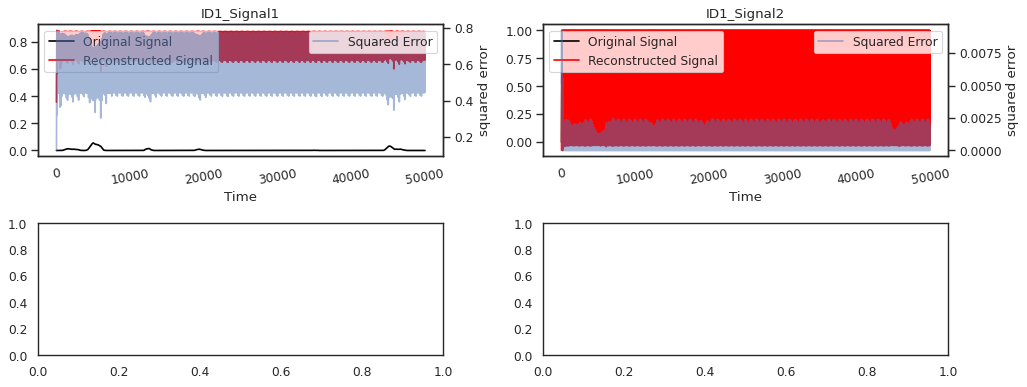

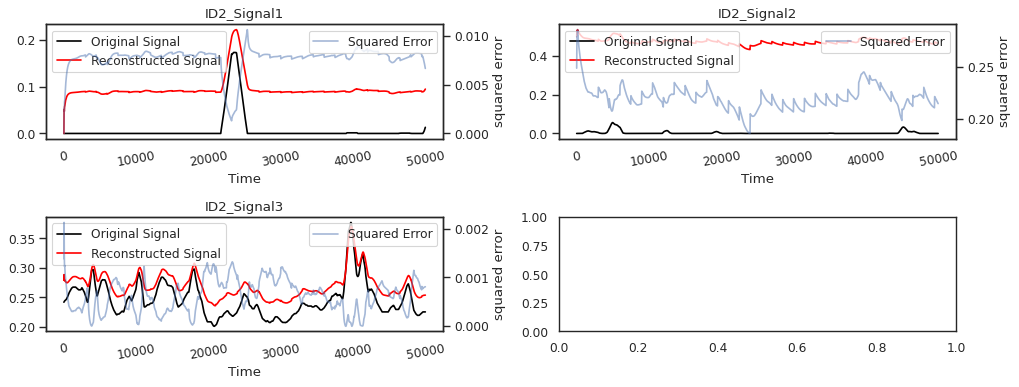

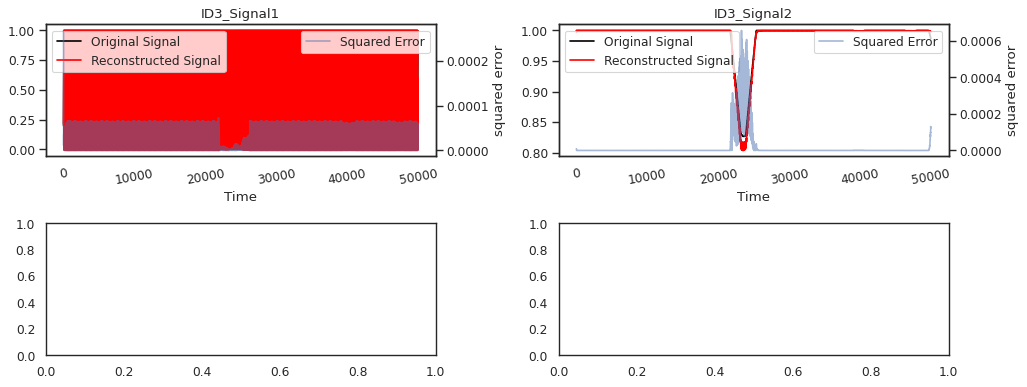

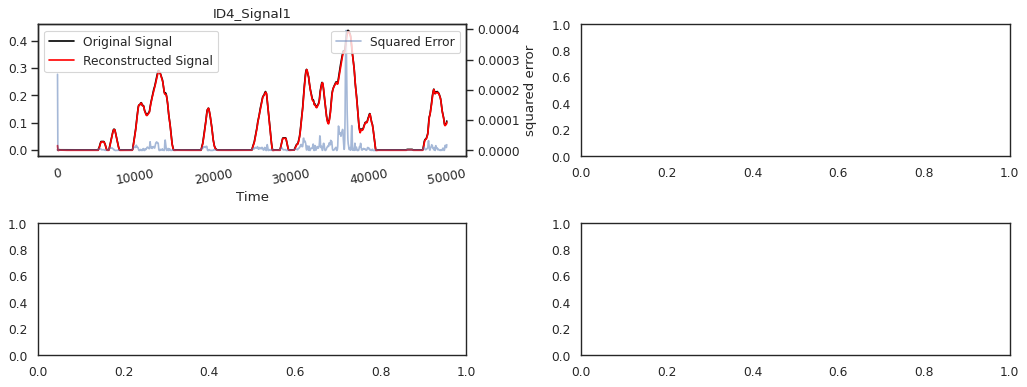

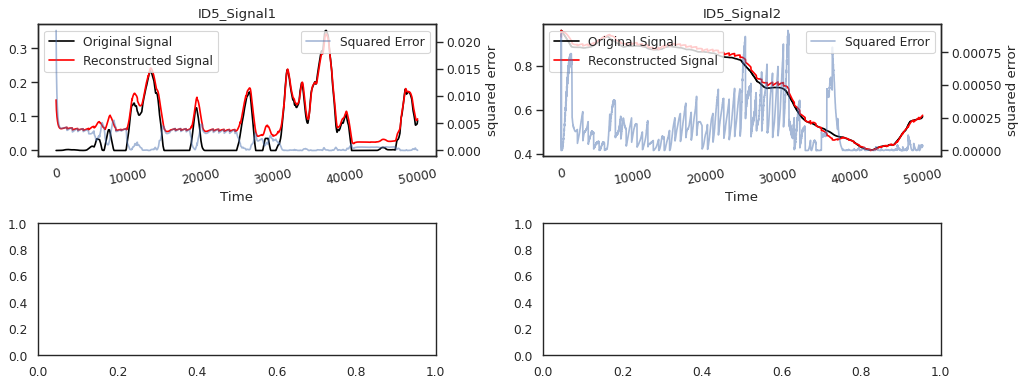

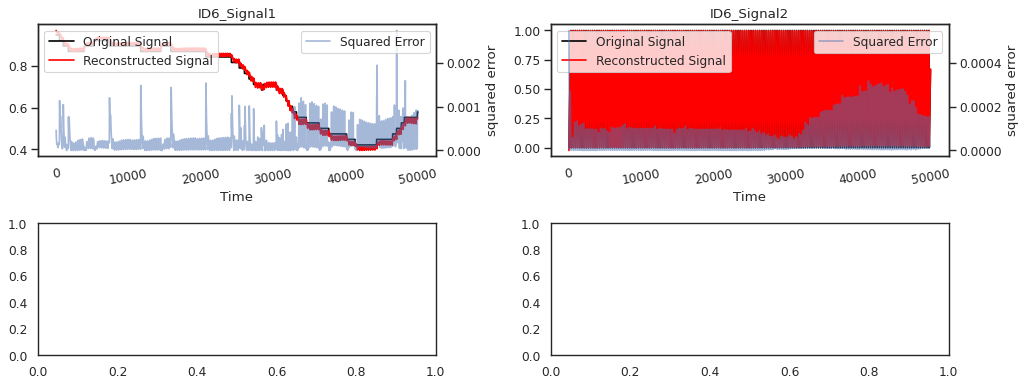

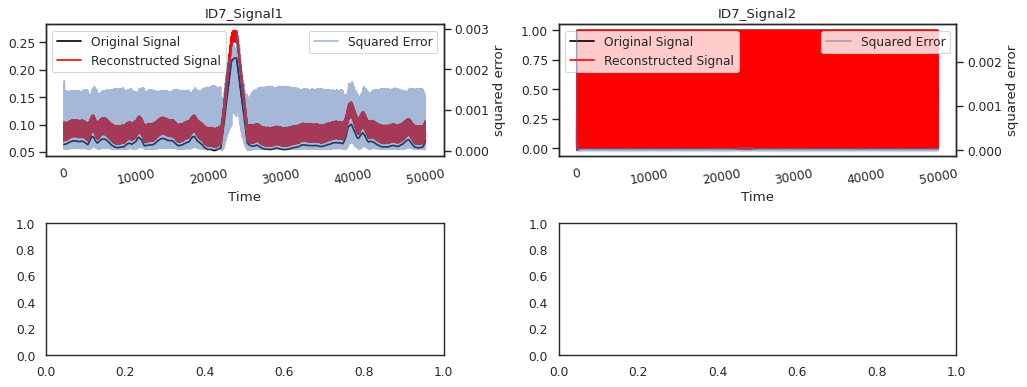

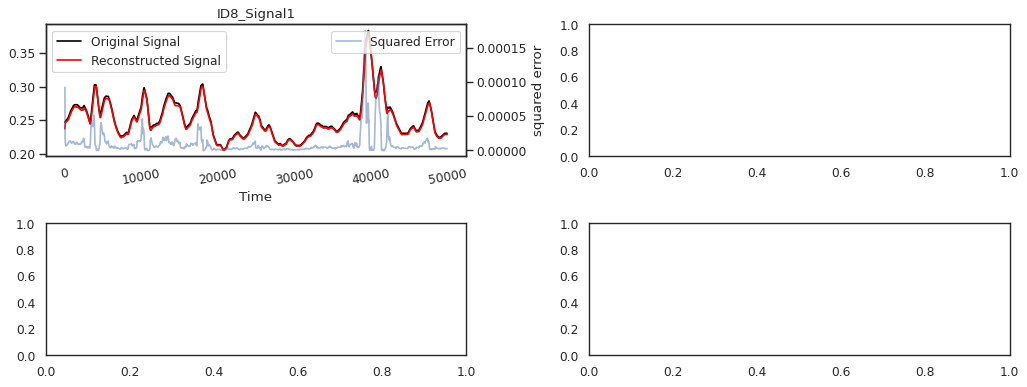

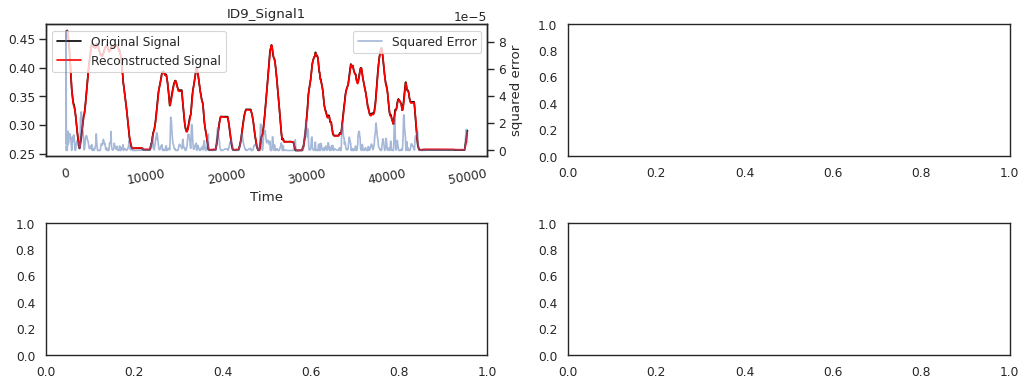

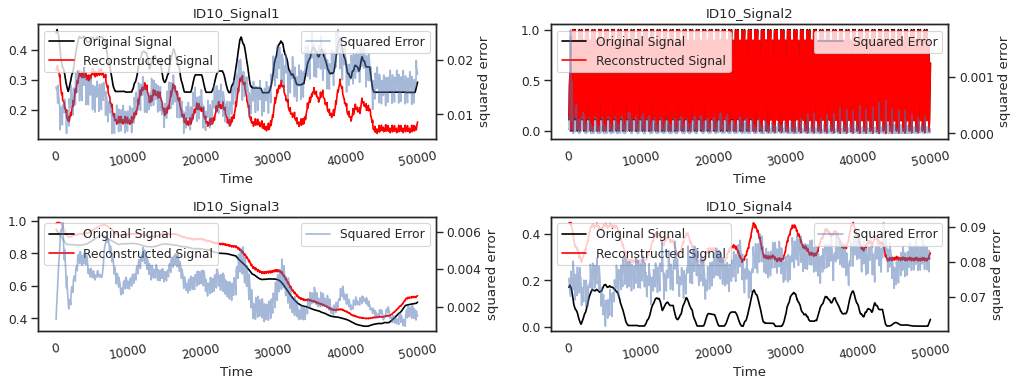

In [ ]:
for df, re in zip(train_dataframes, train_reconstructions):
    visualize_reconstructed_signal(df, re, 0, 5e4, show_se=True)

In [ ]:
thresholds, squared_error = get_thresholds(train_dataframes, train_reconstructions)
for i, t in enumerate(thresholds, 1):
    print(f'ID {i} thresholds: {t}')

In [ ]:
for i, (t, s) in enumerate(zip(thresholds, squared_error), 1):
    print(f'\n ID {i}:')
    for signal in range(s.shape[-1]): # Plot histograms of squared error values and mean + threshold lines
        se = s[:,signal]
        plt.figure(figsize=(12,3))
        sns.set(font_scale = 1)
        sns.set_style("white")
        plt.xlim([0, 2 * t[signal]])
        sns.histplot(np.clip(se, 0, 2 * t[signal]), bins=50, kde=True, color='grey')
        plt.axvline(x=np.mean(se), color='g', linestyle='--', linewidth=3)
        plt.text(np.mean(se), 250, "Mean", horizontalalignment='left', 
                size='small', color='black', weight='semibold')
        plt.axvline(x=t[signal], color='b', linestyle='--', linewidth=3)
        plt.text(t[signal], 250, "Threshold", horizontalalignment='left', 
                size='small', color='Blue', weight='semibold')
        plt.xlabel('Squared Error')
        plt.title('Signal '+str(signal+1))
        sns.despine()
        plt.show()

# Intrusion Detection Evaluation

In [ ]:
def eval_csv2df(dir_path, test_file):  # imports evaluation (abnormal) data into dataframe
    csv_path = dir_path + '/test_' + test_file + '.csv'
    df = pd.read_csv(csv_path, header=None, skiprows=1, names=['Label',  'Time', 'ID',
                                                               'Signal1',  'Signal2',  'Signal3',  'Signal4'])
    return df

def prepare_eval_dataframes(test_file='normal', start_time=0, end_time=None):
    df = eval_csv2df('/content/SynCAN', test_file)
    df['Time'] = df['Time'] - df['Time'].min()      # set starting time to 0
    df = df.set_index(df['Time'])
    end_time = df.Time.max() if not end_time else end_time
    df = df[((df.Time >= start_time) & (df.Time < end_time))]
    # display(df)
    print(f'{len(df):,} total messages (id1,id2,...,id10)\n')
    dataframes = []
    for i in range(10):
        msg_id = 'id'+str(i+1)
        id_df = df[df.ID==msg_id]
        id_df = id_df.dropna(axis=1, how='all') # remove unused signal columns
        length = (len(id_df) // SEQ_STRIDE) * SEQ_STRIDE
        id_df = id_df.iloc[:length]
        dataframes.append(id_df)
        print(f'{msg_id.upper()}: {len(id_df):,} messages')
    return dataframes


## Evaluation using Normal Data

In [ ]:
normal_dataframes = prepare_eval_dataframes(end_time=1e6)
normal_datasets = [SynCAN_ds(id_df) for id_df in normal_dataframes]
for i, ds in enumerate(normal_datasets, 1):
    print(f'ID {i}:\t{ds.__len__().numpy():,} subsequences of length {TIME_STEPS}')

477,739 total messages (id1,id2,...,id10)

ID1: 66,650 messages
ID2: 33,300 messages
ID3: 66,650 messages
ID4: 22,200 messages
ID5: 66,650 messages
ID6: 33,300 messages
ID7: 66,650 messages
ID8: 66,650 messages
ID9: 33,300 messages
ID10: 22,200 messages
ID 1:	1,332 subsequences of length 100
ID 2:	665 subsequences of length 100
ID 3:	1,332 subsequences of length 100
ID 4:	443 subsequences of length 100
ID 5:	1,332 subsequences of length 100
ID 6:	665 subsequences of length 100
ID 7:	1,332 subsequences of length 100
ID 8:	1,332 subsequences of length 100
ID 9:	665 subsequences of length 100
ID 10:	443 subsequences of length 100


In [ ]:
# produce reconstructed signals
normal_reconstructions = [reconstruct(ds, model) for ds, model in zip(normal_datasets, models)]
normal_reconstructions = [re.set_index(df.Time) for df, re in zip(normal_dataframes, normal_reconstructions)]
for re in normal_reconstructions:
    print(re.shape)

443/443 [==============================] - 6s 14ms/step
(66650, 2)
(33300, 3)
(66650, 2)
(22200, 1)
(66650, 2)
(33300, 2)
(66650, 2)
(66650, 1)
(33300, 1)
(22200, 4)


In [ ]:
predictions = get_predictions(normal_dataframes, normal_reconstructions)

[(5.0920000076293945, 125.1020000076294), (155.0920000076294, 999850.752899999)]
[(189719.96790000796, 198029.97790000797), (199259.96790000796, 200159.97790000797), (201929.96790000796, 204569.97790000797), (223649.96790000796, 230669.97790000797), (231089.96790000796, 233669.97790000797), (247049.96790000796, 247469.97790000797), (247529.96790000796, 247529.97790000797), (254609.96790000796, 274319.977900008), (274619.96790000796, 278939.977900008), (282569.96790000796, 283949.977900008), (289859.96790000796, 290789.977900008), (329939.96790000796, 334859.977900008), (469139.96790000796, 474389.977900008), (684119.967900008, 689189.977900008), (697619.967900008, 713969.977900008), (723029.967900008, 723089.977900008), (746789.967900008, 752789.977900008), (844079.967900008, 844289.977900008), (845399.967900008, 846089.977900008), (846719.967900008, 847949.977900008), (859859.967900008, 860429.977900008), (954719.967900008, 955259.977900008), (955859.967900008, 956249.977900008), (961

In [ ]:
false_positive_rate = len(predictions[predictions[0]==1])/len(predictions)
false_positive_rate
# predictions

0.2121557952046906

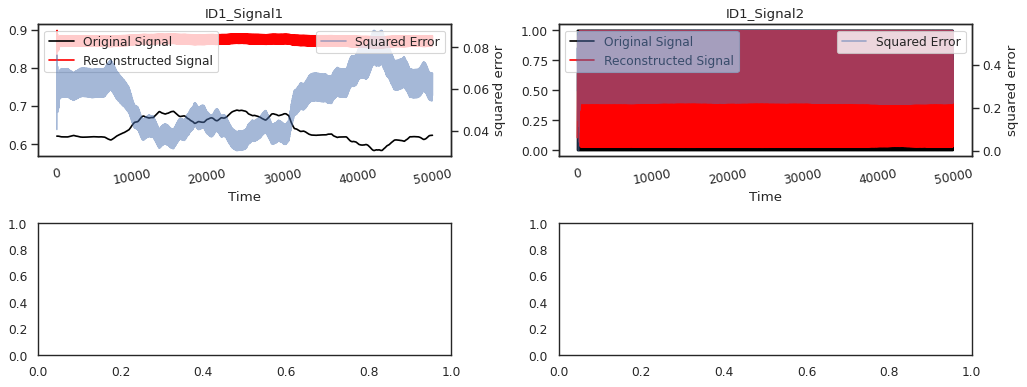

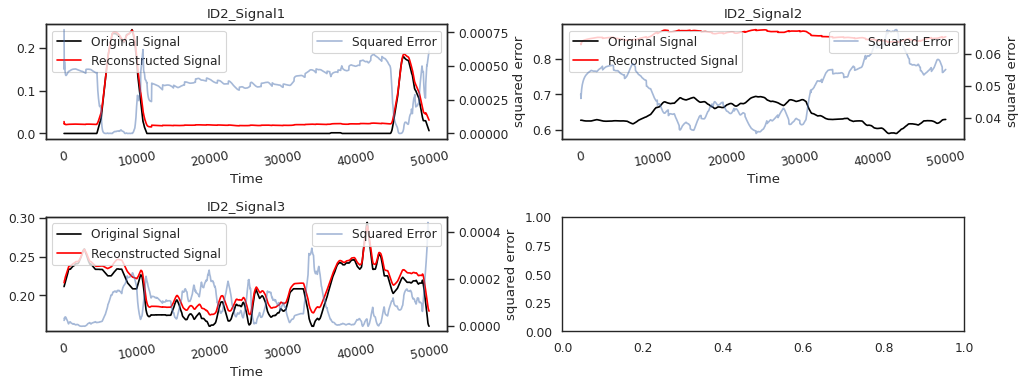

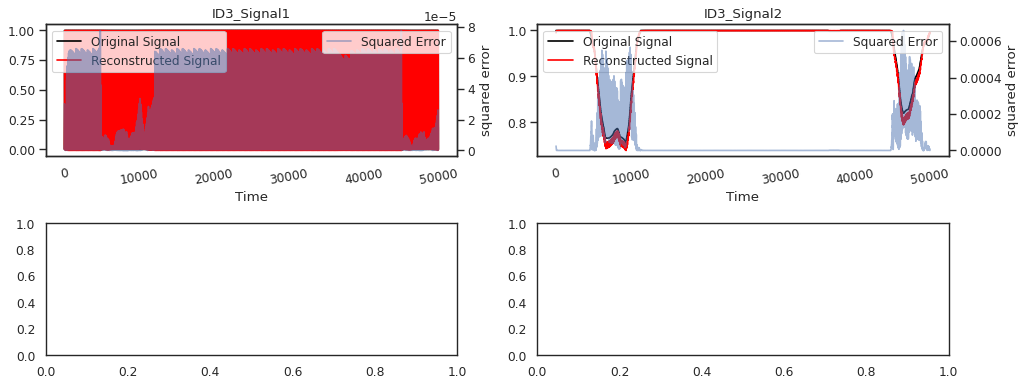

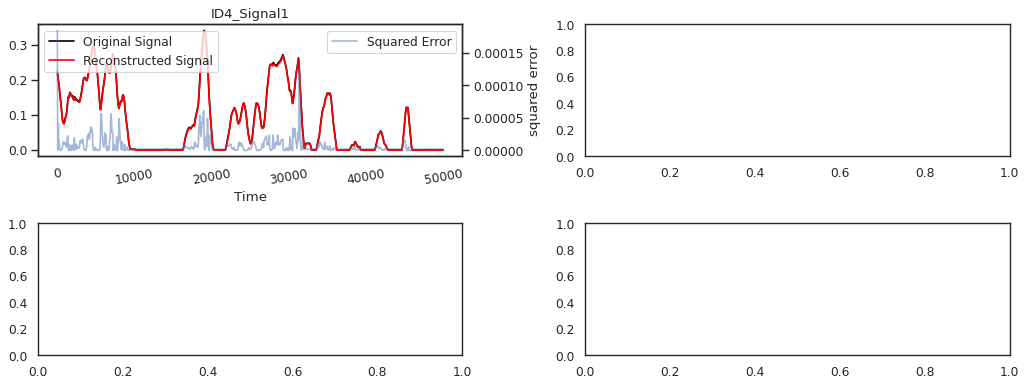

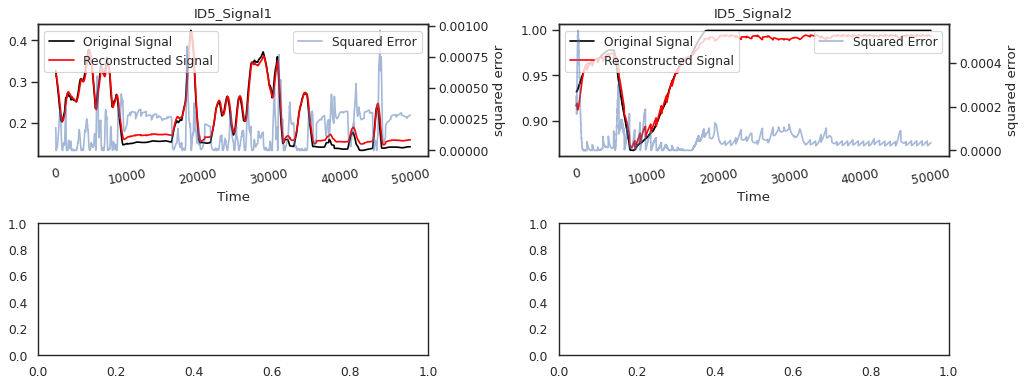

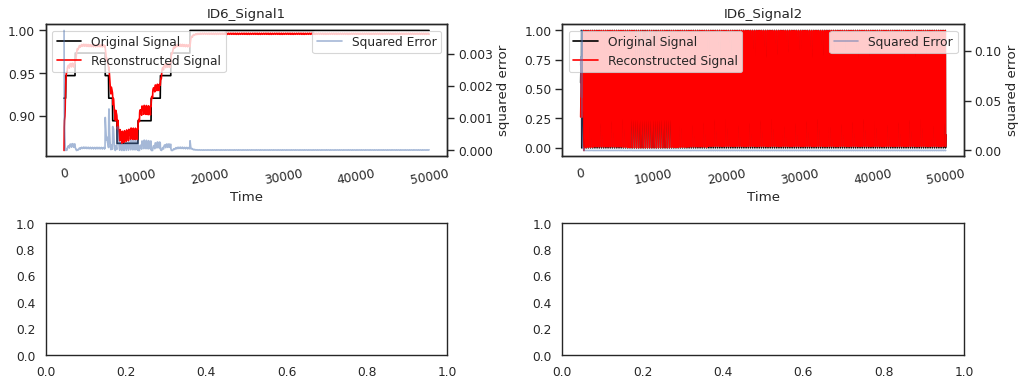

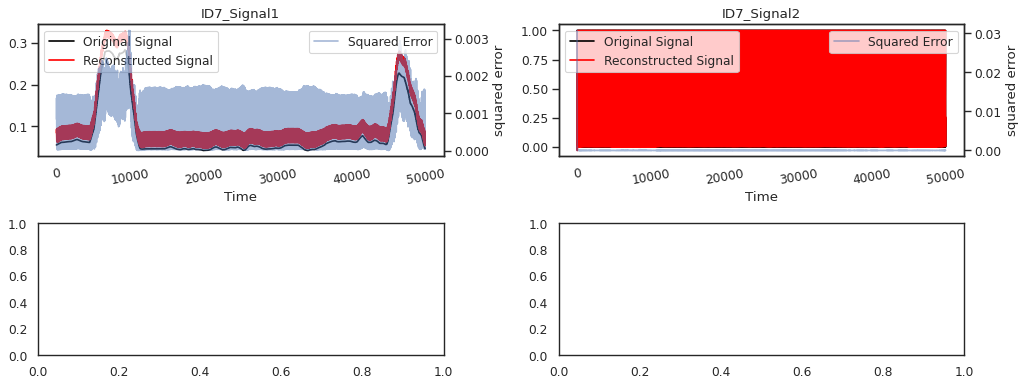

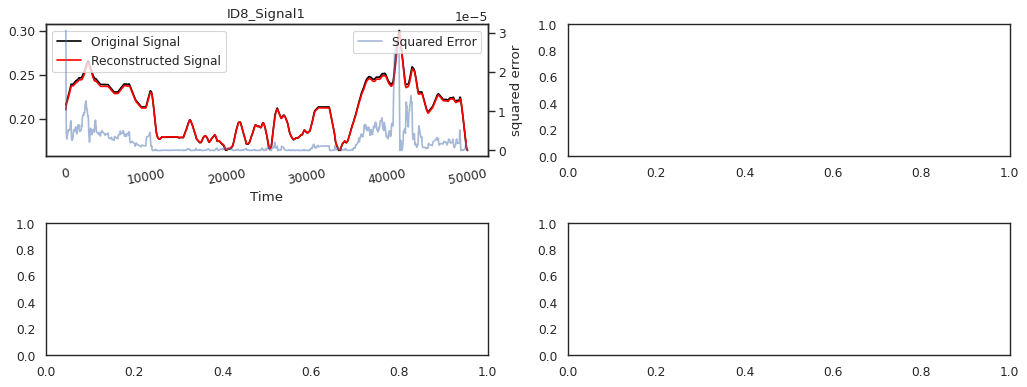

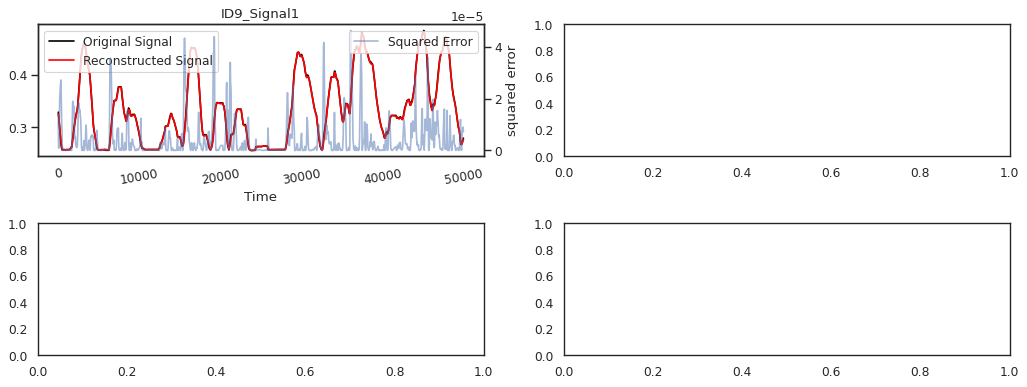

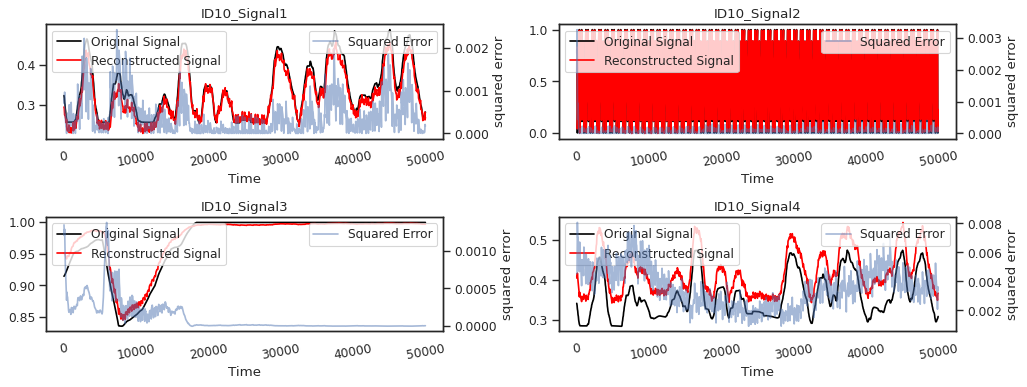

In [ ]:
for df, re in zip(normal_dataframes, normal_reconstructions):
    visualize_reconstructed_signal(df, re, 0, 5e4, show_se=True) 

## Evaluation using Anomalous Data

In [ ]:
eval_dataframes = prepare_eval_dataframes(EVAL_SET)
eval_datasets = [SynCAN_ds(id_df) for id_df in eval_dataframes]

2,150,051 total messages (id1,id2,...,id10)

ID1: 299,950 messages
ID2: 150,000 messages
ID3: 299,950 messages
ID4: 100,000 messages
ID5: 299,950 messages
ID6: 150,000 messages
ID7: 299,950 messages
ID8: 299,950 messages
ID9: 150,000 messages
ID10: 100,000 messages


In [ ]:
eval_reconstructions = [reconstruct(ds, model) for ds, model in zip(eval_datasets, models)]
eval_reconstructions = [re.set_index(df.Time) for df, re in zip(eval_dataframes, eval_reconstructions)]

1999/1999 [==============================] - 33s 17ms/step


AttributeError: ignored

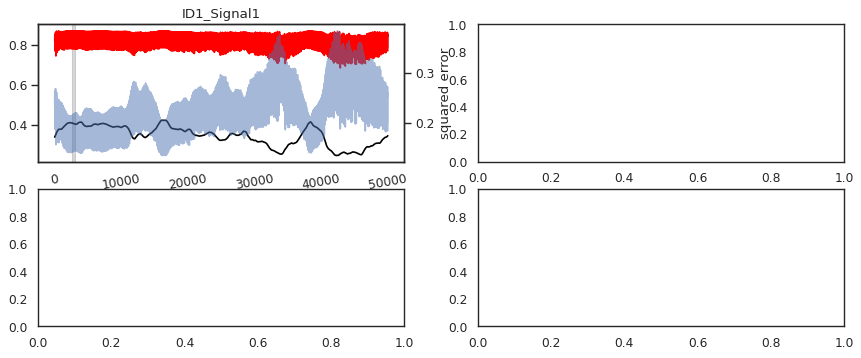

In [ ]:
for df, re in zip(eval_dataframes, eval_reconstructions):
    visualize_reconstructed_signal(df, re, 0, 5e4, predict=True, show_se=True) 
# visualize_reconstructed_signal(eval_df, eval_reconstruction, 1500, 2000, predict=True, show_se=True)

In [ ]:
real_labels = eval_df['Label'].to_numpy()
predictions = np.max(get_predictions(eval_df, eval_reconstruction), axis=1)
cm = confusion_matrix(real_labels, predictions)
cm
# True Neg, False Neg
# False Pos, True Pos

array([[245958,  13852],
       [ 38138,   1952]])

In [ ]:
b_accuracy = balanced_accuracy_score(real_labels, predictions)
print(f'Balanced Accuracy: {b_accuracy}')       # current best: 0.523

Balanced Accuracy: 0.49768728090521164
